# Program - Plot cn_map overlaid with wind vectors

**Content**
- Read data
- Plot cn_map
- Overlay cn_map with wind vectors

**Reference program:**

**Author:**
Yi-Hsuan chen

**Date:**
December 2023

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches
import numpy as np
import xarray as xr
import io, os, sys, types

import yhc_module as yhc

#--- silence dask large chunk and silence the warning.
import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})

xr.set_options(keep_attrs=True)  # keep attributes after xarray operation

## Read data 

### read data

In [23]:
def read_data(choice="0101"):

    #--- datapath
    if (choice == "0101"):
        datapath = "../data_test/"
        fname = datapath+"MERRA2_300.tavg1_2d_slv_Nx.20010710.SUB.test.nc"
    
    da = xr.open_mfdataset(fname)
    da = yhc.wrap360(da)
    
    return da

### select the variable for plotting

In [30]:
def select_var(da, varname, 
               region="NE_CA",
               time = "2001-07-10T02:30:00.000000000"
              ):
    
    var_in = da.get(varname)
    
    if (region == "NE_CA"):
        lowerlon=235; upperlon=245; lowerlat=28; upperlat=35
    else:
        lowerlon=-1000; upperlon=1000; lowerlat=-1000; upperlat=1000
    
    lon_slice = slice(lowerlon, upperlon)
    lat_slice = slice(lowerlat, upperlat)
        
    var_region = var_in.sel(lat=lat_slice, lon=lon_slice, time=time)
    
    return var_region

#-----------
# do_test
#-----------

#do_test=True
do_test=False
    
if (do_test):
    
    da = read_data()
    varname = "TS"
    
    var_2d = select_var(da, varname) #, region=region)

#var_2d

## Plot functions

### ax_def_cn_map

In [10]:
#yhc.lib('fdef')

In [45]:
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

def ax_def_cn_map (ax,
                   map_projection,
                   dict_cn_attrs=None):
    """    
    ----------------------
    Set attributes in cn_map plot using cartopy and matplotlib 

    Input arguments:
        ax: an Axes class variable
        map_projection: ccrs map projection class variable

    Return:
        update ax

    Example:
        map_projection = ccrs.PlateCarree(central_longitude=0)
        fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_projection})
        ax_def_cn_map(ax, map_projection)
      
    References:
      - Cartopy Tick Labels: https://scitools.org.uk/cartopy/docs/latest/gallery/gridlines_and_labels/tick_labels.html

    Date created: 2023-10-15
    ----------------------
    """
    
    #--- add coastline
    ax.add_feature(cfeature.COASTLINE)

    #--- add grid lines
    gl = ax.gridlines(draw_labels=True, linestyle='--', color='gray', alpha = 1)  # add lat/lon grid lines
    gl.top_labels = False     # turn off labels on the top and right sides
    gl.right_labels = False
    
    #--- draw specific grid lines. I try to find a method to draw every grid line but not all labels. I couldn't find an easy way.
    #                              Perhaps the easiest one is to specify grid lines and let the program to determine the labels.
    lon_grid_lines = [-124, -123, -122, -121, -120, -119, -118, -117, -116]
    gl.xlocator = FixedLocator(lon_grid_lines)
    gl.xformatter = LongitudeFormatter(zero_direction_label=True)

    #--- add title 
    fontsize=12
    ax.set_title(dict_cn_attrs['name'], loc='left', fontsize=fontsize)
    ax.set_title(dict_cn_attrs['units'], loc='right', fontsize=fontsize)
    

In [32]:
#yhc.lib('plt_basic')

### set_dict_cn_attrs

In [33]:
#yhc.lib_func('set_cn_attrs')

In [34]:
from matplotlib.colors import BoundaryNorm

def set_dict_cn_attrs (varname):
    """    
    ----------------------
    Set contour attributes

    Input arguments:
        var: an Xarray.DataArray variable
        varname: variable name

    Return:
        1. return  a dictionary variable, dict_cn_attrs = {'cn_levels','cmap',label,name,units'}
 
 
    Example:
        gg = set_cn_attrs(var_tmp, 'tdt_dyn')
        print(gg['units'])

    References:
        colormaps:  https://matplotlib.org/stable/tutorials/colors/colormaps.html

    Date created: 2023-10-15
    ----------------------
    """
    
    #--- set cn levels
    tdt_dyn_cnlevels = np.arange(-25., 27.5, 2.5)
    qdt_dyn_cnlevels = np.arange(-10., 11, 1.)
    
    #---------------------
    # set cn attributes
    #---------------------
    if (varname == "skdfksjdkf"):
        cn_levels = tdt_dyn_cnlevels
        cmap="c1"
        label = "l1"
        name="n1"
        units="u1"
 
    elif (varname == "swabs_toa"):
        cn_levels = 15
        cmap="plasma"
        name = "TOA net downward SW flux"
        units = r"$W m^{-2}$"
        label = name+" ("+units+")"

    else:
        cn_levels = np.array([15])
        cmap = "viridis"
        name = "Var"
        units = "units"
        label = name+" ("+units+")"

    #---------------------------------
    # return a dictionary variable
    #---------------------------------

    dict_cn_attrs = {
        'varname':varname,
        'cn_levels':cn_levels,
        'cmap': cmap,
        'label': label,
        'name': name,
        'units': units,
                  }
    
    return dict_cn_attrs

#-----------
# do_test
#-----------

#do_test=True
do_test=False

if (do_test):
    var_tmp = xr.DataArray(1)
    var_tmp.attrs['standard_name']="ggg"
    var_tmp.attrs['units']="KK"

    dict_cn_attrs = set_dict_cn_attrs('swabs_toa_diff')
    print(dict_cn_attrs)
    print(dict_cn_attrs['cmap'])

In [35]:
#yhc.lib('np')

### plot_box

In [36]:
def plot_box(ax, region="DYCOMS"):
    
    if (region == "DYCOMS"): 
        region_name = "DYCOMS (30-32.2N, 120-123.8W)"
        lowerlat =  30.    # 30N
        upperlat =  32.2   # 32.2N
        lowerlon =  236.2  # 123.8W
        upperlon =  240.   # 120W
    
    lon_range = upperlon - lowerlon
    lat_range = upperlat - lowerlat

    rect = mpatches.Rectangle((lowerlon, lowerlat), lon_range, lat_range, facecolor='none', edgecolor='cyan', linewidth=2, transform=map_projection)
    ax.add_patch(rect)
        

### plot_cn_map

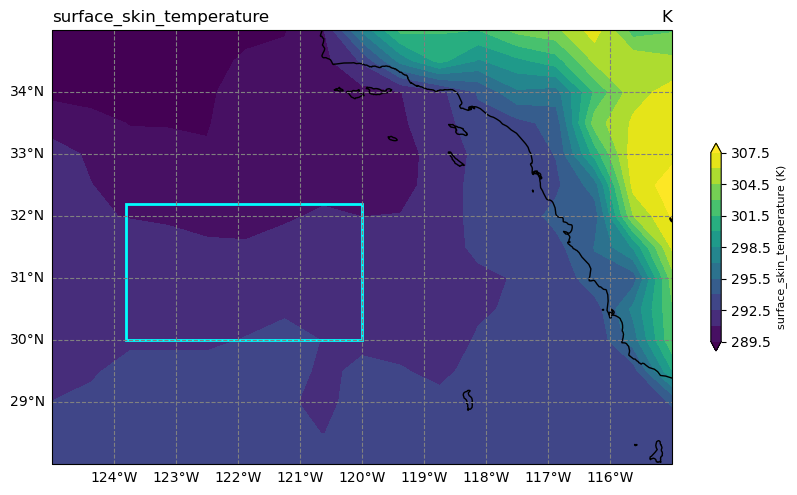

In [49]:
from matplotlib.ticker import FixedLocator

def plot_cn_map(ax, map_projection,
                var, varname,
                do_set_cn_attrs = True, 
                lb_orientation='vertical', lb_shrink=0.45, lb_fontsize=8, 
               ):

    #-------------
    # plot cn_map
    #-------------
    
    if (do_set_cn_attrs):
        dict_cn_attrs = set_dict_cn_attrs(varname)  # set contour attributie
        cn_map_region = ax.contourf(var.lon, var.lat, var, extend='both', transform=map_projection, levels=dict_cn_attrs['cn_levels'], cmap=dict_cn_attrs['cmap']) 

    else:
        name = var.attrs['long_name']
        units = var.attrs['units']
        label = name+" ("+units+")"
        
        dict_cn_attrs = {
            'varname':varname,
            'cmap': "viridis",
            'label': label,
            'name': name,
            'units': units,
        }
        
        cn_map_region = ax.contourf(var.lon, var.lat, var, 15, transform=map_projection, extend='both') 
        
    #--- set cn_map attributes
    ax_def_cn_map(ax, map_projection, dict_cn_attrs=dict_cn_attrs)
    
    #--- plot the colorbar
    cbar = plt.colorbar(cn_map_region, ax=ax, orientation=lb_orientation, shrink=lb_shrink) #, label=dict_cn_attrs['label'])
    #cbar.ax.tick_params(axis='both', which='major', labelsize=5)
    cbar.set_label(label=dict_cn_attrs['label'], fontsize=lb_fontsize)
    
    #-------------
    # plot DYCOMS region
    #-------------    
    plot_box(ax)
    
#-----------
# do_test
#-----------

do_test=True
#do_test=False
    
if (do_test):
    map_projection = ccrs.PlateCarree(central_longitude=0)
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_projection})

    da = read_data()
    varname = "TS"
    var_2d = select_var(da, varname)
    do_set_cn_attrs = False
    
    plot_cn_map(ax, map_projection, var_2d, varname, do_set_cn_attrs=do_set_cn_attrs)